#2a

In [23]:
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
import os

class ImageProcessor:
    def __init__(self):
        self.dataset_dir = r"D:\data_mining"
        self.img_dir = r"D:\data_mining\Images"
        self.annotation_dir = r"D:\data_mining\Annotation"
        self.cropped_dir = r"D:\data_mining\Cropped"

    def _extract_bounding_boxes(self, annotation_path):
        tree = ET.parse(annotation_path)
        objects = tree.findall('object')

        # Extract and return bounding box coordinates (xmin, ymin, xmax, ymax)
        bounding_boxes = [
            (
                int(bndbox.find('xmin').text),
                int(bndbox.find('ymin').text),
                int(bndbox.find('xmax').text),
                int(bndbox.find('ymax').text)
            )
            for obj in objects for bndbox in [obj.find('bndbox')]
        ]
        return bounding_boxes

    def _get_corresponding_image_path(self, annotation_path):
        image_name = annotation_path.stem + '.jpg'
        breed_name = annotation_path.parent.name
        return Path(self.img_dir) / breed_name / image_name

    def process_images(self, breeds):
        for breed in breeds:
            breed_annotation_dir = Path(self.annotation_dir).joinpath(breed)
            if not breed_annotation_dir.exists():
                print(f"Directory not found: {breed_annotation_dir}")
                continue
            
            print(f"Scanning directory: {breed_annotation_dir}")
            breed_annotations = list(breed_annotation_dir.glob('*'))  # Only select XML annotation files
            
            print(f"Found {len(breed_annotations)} annotations for breed: {breed}")
            
            if not breed_annotations:
                print(f"No annotation files for breed: {breed}. Check the directory.")
            
            for annotation_file in breed_annotations:
                if annotation_file.is_file():
                    self._process_annotation(annotation_file)

    def _process_annotation(self, annotation_path):
        print(f"Processing annotation: {annotation_path}")
        bounding_boxes = self._extract_bounding_boxes(annotation_path)
        image_path = self._get_corresponding_image_path(annotation_path)

        if not image_path.exists():
            print(f"Corresponding image not found: {image_path}")
            return

        with Image.open(image_path) as img:
            for idx, bbox in enumerate(bounding_boxes):
                cropped_img = img.crop(bbox).resize((128, 128), Image.LANCZOS).convert('RGB')
                self._save_cropped_image(cropped_img, image_path, idx)

    def _save_cropped_image(self, img, original_image_path, index):
        relative_path = original_image_path.relative_to(self.img_dir)
        new_file_name = f"{relative_path.stem}-{index}.jpg"
        output_path = Path(self.cropped_dir) / relative_path.with_name(new_file_name)
        output_path.parent.mkdir(parents=True, exist_ok=True)

        img.save(output_path)
        print(f"Cropped image saved: {output_path}")

if __name__ == "__main__":
    processor = ImageProcessor()
    breeds_to_process = [
        'n02086910-papillon',
        'n02088632-bluetick',
        'n02096437-Dandie_Dinmont',
        'n02113023-Pembroke'
    ]
    processor.process_images(breeds_to_process)


Scanning directory: D:\data_mining\Annotation\n02086910-papillon
Found 196 annotations for breed: n02086910-papillon
Processing annotation: D:\data_mining\Annotation\n02086910-papillon\n02086910_10147
Cropped image saved: D:\data_mining\Cropped\n02086910-papillon\n02086910_10147-0.jpg
Processing annotation: D:\data_mining\Annotation\n02086910-papillon\n02086910_10204
Cropped image saved: D:\data_mining\Cropped\n02086910-papillon\n02086910_10204-0.jpg
Processing annotation: D:\data_mining\Annotation\n02086910-papillon\n02086910_103
Cropped image saved: D:\data_mining\Cropped\n02086910-papillon\n02086910_103-0.jpg
Processing annotation: D:\data_mining\Annotation\n02086910-papillon\n02086910_1048
Cropped image saved: D:\data_mining\Cropped\n02086910-papillon\n02086910_1048-0.jpg
Processing annotation: D:\data_mining\Annotation\n02086910-papillon\n02086910_1052
Cropped image saved: D:\data_mining\Cropped\n02086910-papillon\n02086910_1052-0.jpg
Processing annotation: D:\data_mining\Annotati

#2b

Loading image from: D:\data_mining\cropped\n02086910-papillon\n02086910_21-0.jpg


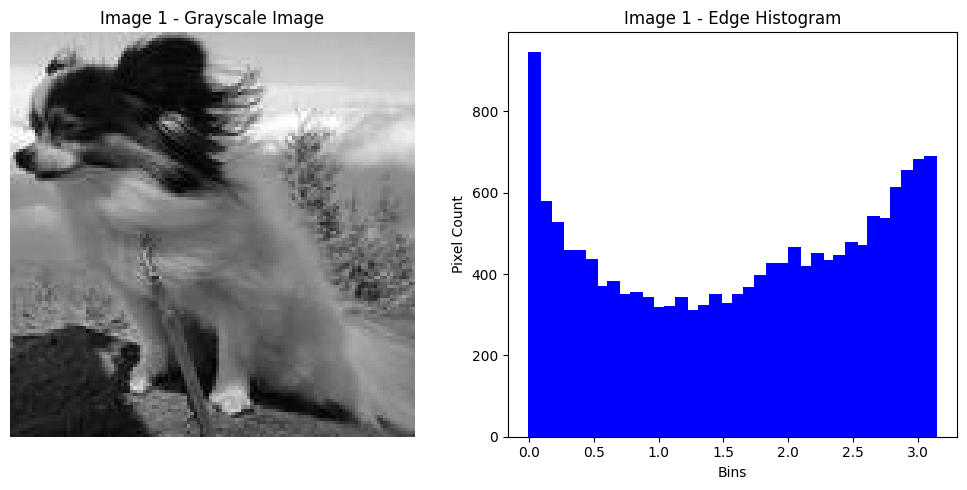

Loading image from: D:\data_mining\cropped\n02088632-bluetick\n02088632_28-0.jpg


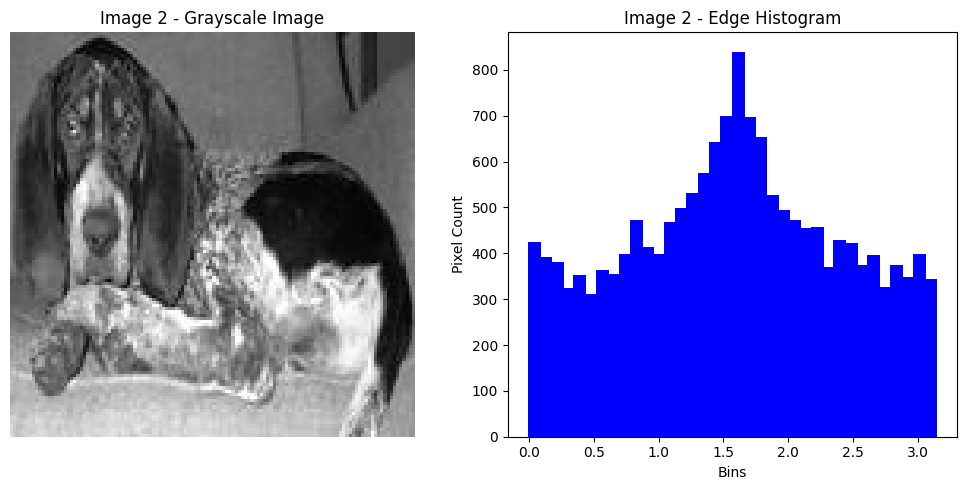

Loading image from: D:\data_mining\cropped\n02096437-Dandie_Dinmont\n02096437_4-0.jpg


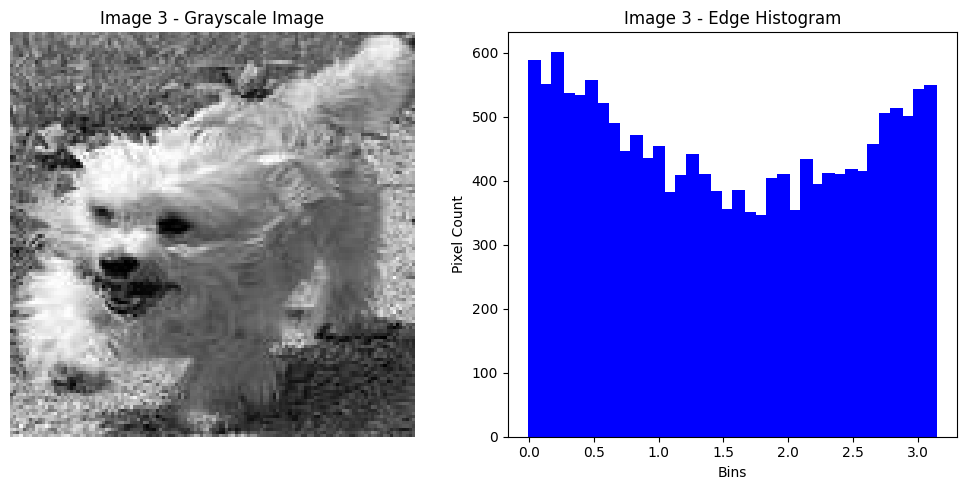

Loading image from: D:\data_mining\cropped\n02113023-Pembroke\n02113023_186-0.jpg


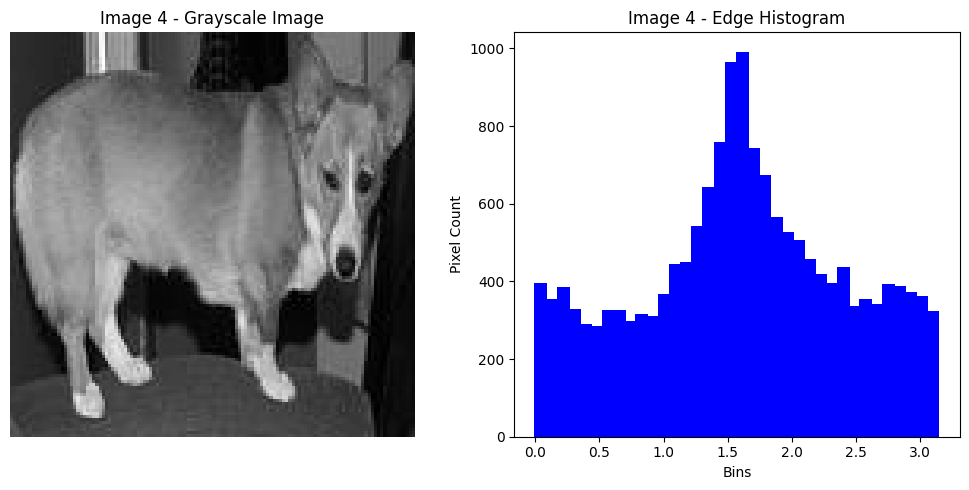

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters, exposure
from sklearn.metrics import pairwise_distances
import cv2
from pathlib import Path

def load_convert_image(image_path):
    print(f"Loading image from: {image_path}")  # Debug message
    image = cv2.imread(str(image_path))
    
    if image is None:
        print(f"Error: Could not load image at {image_path}")  # Error message
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    grayscale_image = color.rgb2gray(image_rgb)
    return grayscale_image

def calculate_edge_angles(image):
    sobel_h = filters.sobel_h(image)
    sobel_v = filters.sobel_v(image)
    angle = np.mod(np.arctan2(sobel_v, sobel_h), np.pi)  # Limit angles to range [0, pi]
    return angle

def generate_hist(image_angle, bins=36):
    hist, hist_centers = exposure.histogram(image_angle, nbins=bins)
    return hist, hist_centers

def plot_image_hist(image, hist, centers, title):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"{title} - Grayscale Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.bar(centers, hist, width=0.1, align='center', color='blue')
    plt.title(f"{title} - Edge Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
    
    plt.tight_layout()
    plt.show()

def main():
    image_paths = [
        Path(r"D:\data_mining\cropped\n02086910-papillon\n02086910_21-0.jpg"),  # Update with actual file names
        Path(r"D:\data_mining\cropped\n02088632-bluetick\n02088632_28-0.jpg"),
        Path(r"D:\data_mining\cropped\n02096437-Dandie_Dinmont\n02096437_4-0.jpg"),
        Path(r"D:\data_mining\cropped\n02113023-Pembroke\n02113023_186-0.jpg")
    ]

    for i, image_path in enumerate(image_paths, start=1):
        image = load_convert_image(image_path)
        if image is not None:
            # Calculate edge angles
            image_angle = calculate_edge_angles(image)
            # Generate histogram of edge angles
            hist, centers = generate_hist(image_angle)
            # Plot the grayscale image and histogram
            plot_image_hist(image, hist, centers, f"Image {i}")
        else:
            print(f"Skipping Image {i} due to loading issues.")

if __name__ == "__main__":
    main()


#2b

Loading image from: D:\data_mining\cropped\n02086910-papillon\n02086910_21-0.jpg
Loading image from: D:\data_mining\cropped\n02088632-bluetick\n02088632_28-0.jpg
Loading image from: D:\data_mining\cropped\n02096437-Dandie_Dinmont\n02096437_4-0.jpg
Loading image from: D:\data_mining\cropped\n02113023-Pembroke\n02113023_186-0.jpg
Image 1: Loaded
Image 2: Loaded
Image 3: Loaded
Image 4: Loaded


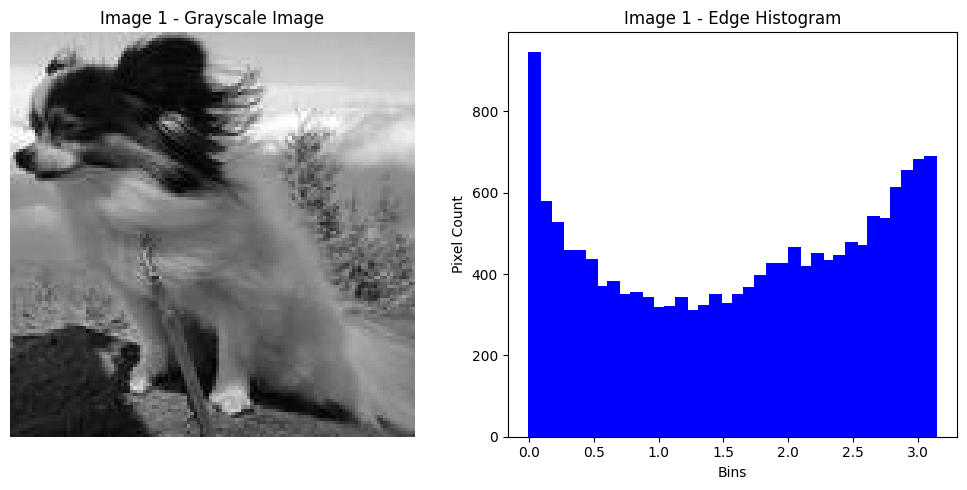

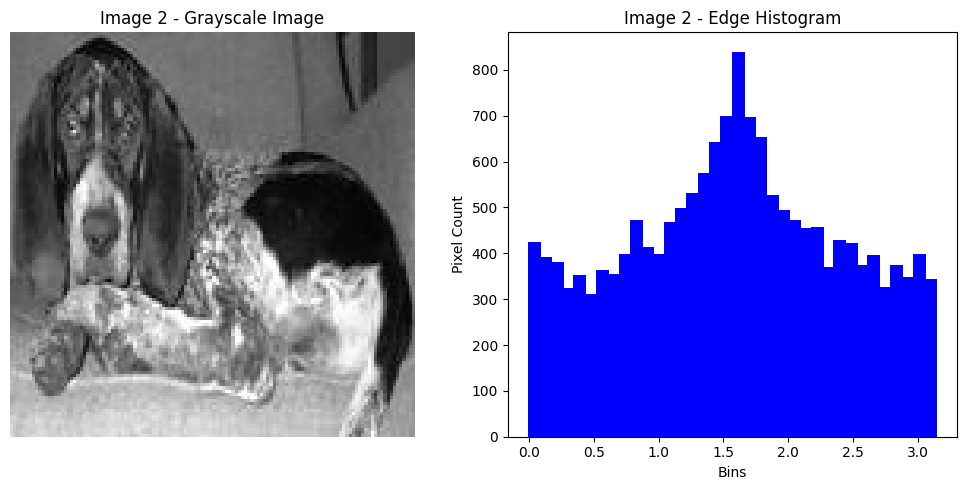

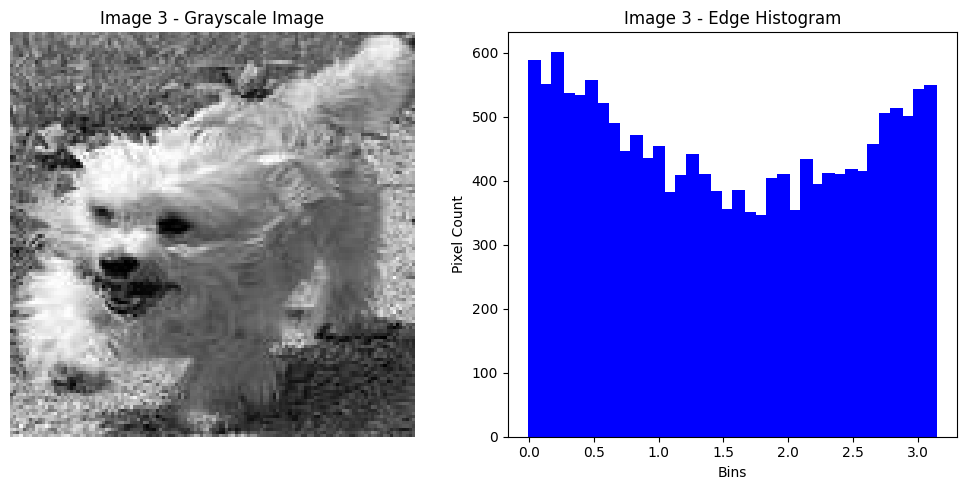

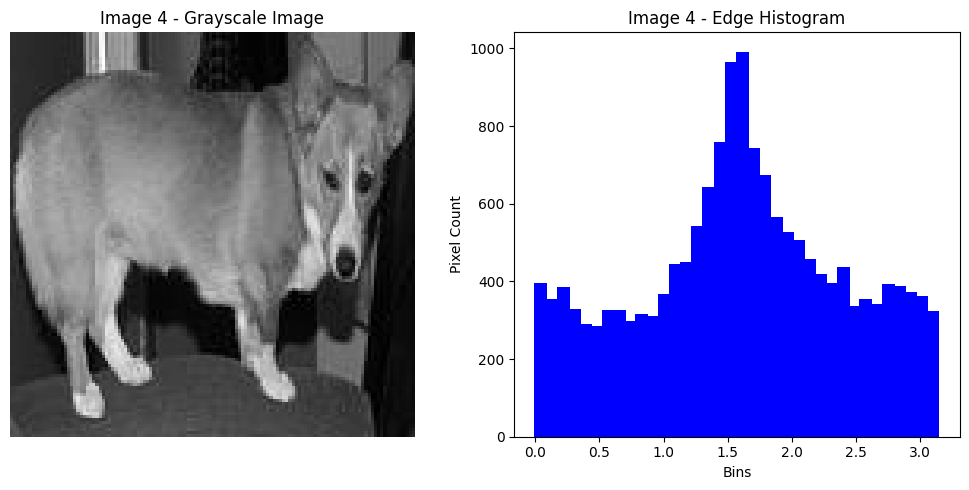

Comparison between Image 1 and Image 2:
Euclidean Distance: 1282.2152705376739
Manhattan Distance: 6060.0
Cosine Distance: 0.1022762807297114


In [5]:
def compare_histograms(hist1, hist2):
    hist1 = hist1.reshape(1, -1)
    hist2 = hist2.reshape(1, -1)
    
    euclidean_distance = pairwise_distances(hist1, hist2, metric='euclidean')[0][0]
    
    # Manhattan distance
    manhattan_distance = pairwise_distances(hist1, hist2, metric='manhattan')[0][0]
    
    #Cosine distance
    cosine_distance = pairwise_distances(hist1, hist2, metric='cosine')[0][0]
    
    return euclidean_distance, manhattan_distance, cosine_distance


if __name__ == "__main__":

    image_paths = [
        Path(r"D:\data_mining\cropped\n02086910-papillon\n02086910_21-0.jpg"),  
        Path(r"D:\data_mining\cropped\n02088632-bluetick\n02088632_28-0.jpg"),
        Path(r"D:\data_mining\cropped\n02096437-Dandie_Dinmont\n02096437_4-0.jpg"),
        Path(r"D:\data_mining\cropped\n02113023-Pembroke\n02113023_186-0.jpg")
    ]
    
    image1 = load_convert_image(image_paths[0])
    image2 = load_convert_image(image_paths[1])
    image3 = load_convert_image(image_paths[2])
    image4 = load_convert_image(image_paths[3])
    
    # Debugging: print the status of image loading
    print(f"Image 1: {'Loaded' if image1 is not None else 'Failed to load'}")
    print(f"Image 2: {'Loaded' if image2 is not None else 'Failed to load'}")
    print(f"Image 3: {'Loaded' if image3 is not None else 'Failed to load'}")
    print(f"Image 4: {'Loaded' if image4 is not None else 'Failed to load'}")
    
    if all(image is not None for image in [image1, image2, image3, image4]):
        angle_img1 = calculate_edge_angles(image1)
        angle_img2 = calculate_edge_angles(image2)
        angle_img3 = calculate_edge_angles(image3)
        angle_img4 = calculate_edge_angles(image4)
        
        hist1, centers1 = generate_histogram(angle_img1)
        hist2, centers2 = generate_histogram(angle_img2)
        hist3, centers3 = generate_histogram(angle_img3)
        hist4, centers4 = generate_histogram(angle_img4)
        
        plot_image_hist(image1, hist1, centers1, "Image 1")
        plot_image_hist(image2, hist2, centers2, "Image 2")
        plot_image_hist(image3, hist3, centers3, "Image 3")
        plot_image_hist(image4, hist4, centers4, "Image 4")
        
        euclidean, manhattan, cosine = compare_histograms(hist1, hist2)
        
        print(f"Comparison between Image 1 and Image 2:")
        print(f"Euclidean Distance: {euclidean}")
        print(f"Manhattan Distance: {manhattan}")
        print(f"Cosine Distance: {cosine}")


#2c

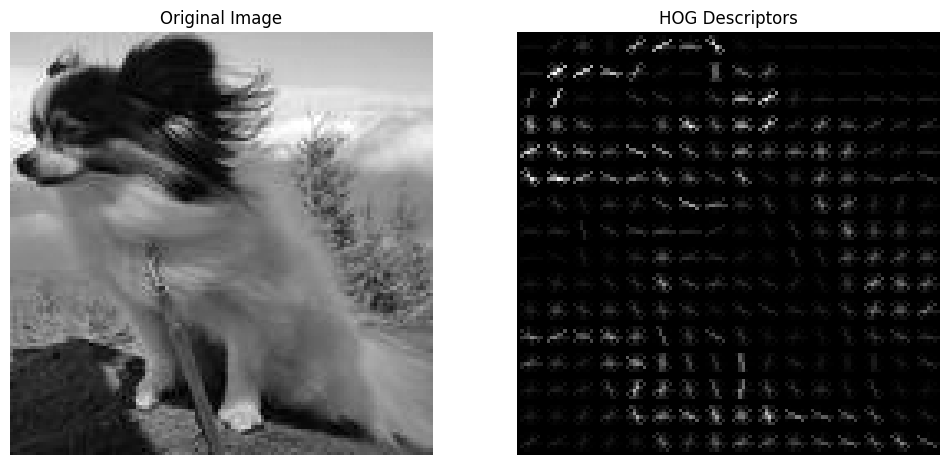

In [45]:
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.feature import hog
from skimage import exposure

image = io.imread(r'D:\data_mining\cropped\n02086910-papillon\n02086910_21-0.jpg')

grayscale_image = color.rgb2gray(image)

hog_descriptors, hog_image = hog(grayscale_image, 
                                 orientations=9, 
                                 pixels_per_cell=(8, 8), 
                                 cells_per_block=(2, 2), 
                                 block_norm='L2-Hys', 
                                 visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(grayscale_image, cmap=plt.cm.gray)
ax1.set_title('Original Image')

ax2.axis('off')
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG Descriptors')

plt.show()


#2d

Attempting to load image from: D:\data_mining\cropped\n02086910-papillon\n02086910_10147-0.jpg
Image loaded successfully: D:\data_mining\cropped\n02086910-papillon\n02086910_10147-0.jpg
Attempting to load image from: D:\data_mining\cropped\n02086910-papillon\n02086910_10204-0.jpg
Image loaded successfully: D:\data_mining\cropped\n02086910-papillon\n02086910_10204-0.jpg
Attempting to load image from: D:\data_mining\cropped\n02086910-papillon\n02086910_103-0.jpg
Image loaded successfully: D:\data_mining\cropped\n02086910-papillon\n02086910_103-0.jpg
Attempting to load image from: D:\data_mining\cropped\n02086910-papillon\n02086910_1048-0.jpg
Image loaded successfully: D:\data_mining\cropped\n02086910-papillon\n02086910_1048-0.jpg
Attempting to load image from: D:\data_mining\cropped\n02086910-papillon\n02086910_1052-0.jpg
Image loaded successfully: D:\data_mining\cropped\n02086910-papillon\n02086910_1052-0.jpg
Attempting to load image from: D:\data_mining\cropped\n02086910-papillon\n0208

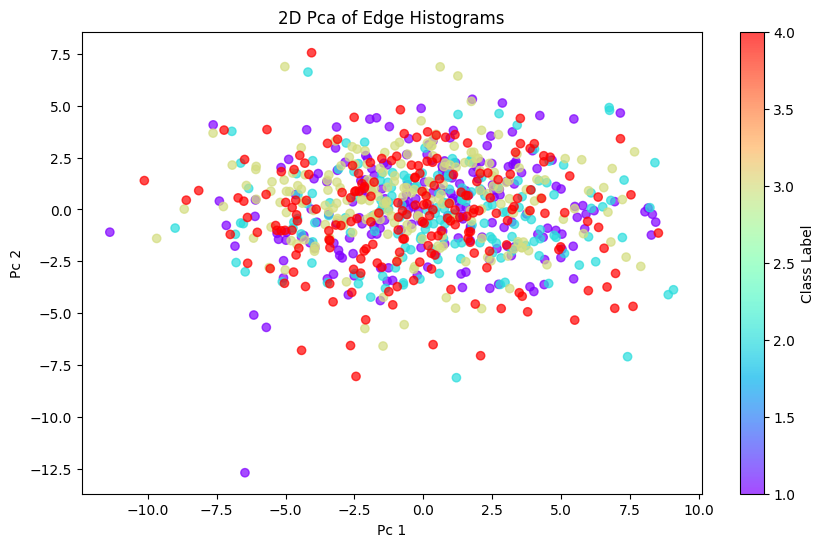

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class EdgeHistogramPCAVisualizer:
    def __init__(self, class1_images_dir, class2_images_dir, class3_images_dir, class4_images_dir):
        self.class1_dir = Path(class1_images_dir)
        self.class2_dir = Path(class2_images_dir)
        self.class3_dir = Path(class3_images_dir)
        self.class4_dir = Path(class4_images_dir)

    @staticmethod
    def _compute_edge_histogram(image_path):
        """Compute edge histogram for an image."""
        print(f"Attempting to load image from: {image_path}")
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"Failed to load image: {image_path}")
            return None
    
        print(f"Image loaded successfully: {image_path}")
        
        edges = cv2.Canny(img, 100, 200)
        
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_direction = np.arctan2(sobel_y, sobel_x)  # Gradient direction
        
        hist, _ = np.histogram(gradient_direction, bins=36, range=(-np.pi, np.pi))
        return hist

    def _collect_hist(self):
        histograms = []
        labels = []  # Class labels for coloring the PCA plot
        class1_files = list(self.class1_dir.glob("*.jpg"))
        class2_files = list(self.class2_dir.glob("*.jpg"))
        class3_files = list(self.class3_dir.glob("*.jpg"))
        class4_files = list(self.class4_dir.glob("*.jpg"))
        all_files = [(class1_files, 1), (class2_files, 2), (class3_files, 3), (class4_files, 4)]

        for class_files, class_label in all_files:
            for file in class_files:
                hist = self._compute_edge_histogram(file)
                if hist is not None:
                    histograms.append(hist)
                    labels.append(class_label)

        return np.array(histograms), np.array(labels)

    def visualize_pca(self):
        histograms, labels = self._collect_hist()

        if len(histograms) == 0:
            print("No histograms were collected")
            return

        histograms = StandardScaler().fit_transform(histograms)

        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(histograms)

        # Plot the 2D points using different colors for each class
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='rainbow', alpha=0.7)
        plt.xlabel('Pc 1')
        plt.ylabel('Pc 2')
        plt.title('2D Pca of Edge Histograms')
        plt.colorbar(scatter, label="Class Label")
        plt.show()


if __name__ == "__main__":
   
    class1_images_path = r'D:\data_mining\cropped\n02086910-papillon'
    class2_images_path = r'D:\data_mining\cropped\n02088632-bluetick'
    class3_images_path = r'D:\data_mining\cropped\n02096437-Dandie_Dinmont'
    class4_images_path = r'D:\data_mining\cropped\n02113023-Pembroke'

    pca_visualizer = EdgeHistogramPCAVisualizer(class1_images_path, class2_images_path, class3_images_path, class4_images_path)

    pca_visualizer.visualize_pca()


2D)iv) None of classes are visually seperate

In [ ]:
#4

In [47]:
import json
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

def load_training_set_line_by_line(file_path):
    dataset = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                dataset.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {line}\nError: {e}")
    return dataset

def extract_texts_and_labels(dataset):
    texts = []
    labels = []
    for entry in dataset:
        if 'Tweet' in entry:
            texts.append(entry['Tweet'])
            emotion_labels = [key for key, value in entry.items() if value is True and key != 'ID']
            if emotion_labels:
                labels.append(emotion_labels[0])  # Assuming the first True value as the label
            
        else:
            print(f"Missing 'Tweet' in entry: {entry}")
    return texts, labels

def vectorize_texts(texts):
    
    count_vectorizer = CountVectorizer()
    X_counts = count_vectorizer.fit_transform(texts)
    
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(texts)
    
    count_dim = X_counts.shape
    tfidf_dim = X_tfidf.shape
    
    return X_counts, X_tfidf, count_dim, tfidf_dim

def main():
    file_path = r'D:\data_mining\student_12\train.json'  

    training_data = load_training_set_line_by_line(file_path)

    tweet_texts, tweet_labels = extract_texts_and_labels(training_data)

    if not tweet_texts or not tweet_labels:
        print("No valid data found. Exiting.")
        return

    X_counts, X_tfidf, count_dim, tfidf_dim = vectorize_texts(tweet_texts)

    print(f"CountVectorizer feature dimensionality: {count_dim}")
    print(f"TfidfVectorizer feature dimensionality: {tfidf_dim}")

if __name__ == "__main__":
    main()


CountVectorizer feature dimensionality: (3000, 9709)
TfidfVectorizer feature dimensionality: (3000, 9709)


#5

Class distribution: Counter({'anger': 1099, 'joy': 993, 'sadness': 418, 'trust': 36})
Count Vectorizer Dimensionality: 8731
TF-IDF Vectorizer Dimensionality: 8731


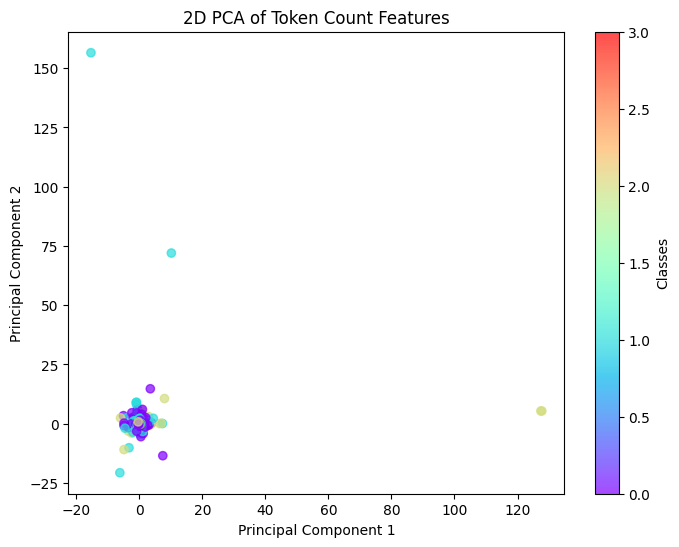

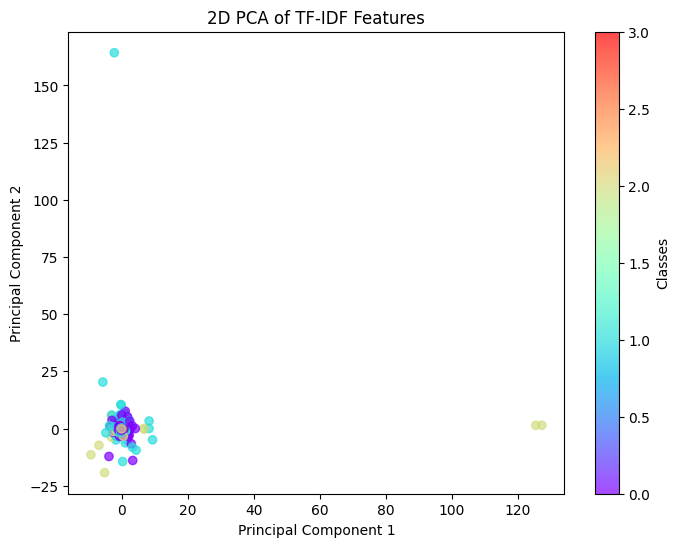

In [48]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter

def load_dataset_line_by_line(file_path):
    dataset = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                dataset.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line: {line}")
                continue
    return dataset

def extract_texts_and_labels(dataset):
    texts = []
    labels = []
    for entry in dataset:
        if 'Tweet' in entry and any([entry['anger'], entry['joy'], entry['sadness'], entry['trust']]):
            texts.append(entry['Tweet'])
            if entry['anger']:
                labels.append('anger')
            elif entry['joy']:
                labels.append('joy')
            elif entry['sadness']:
                labels.append('sadness')
            elif entry['trust']:
                labels.append('trust')
    return texts, labels

def vectorize_texts(texts):
    count_vectorizer = CountVectorizer()
    tfidf_vectorizer = TfidfVectorizer()
    
    X_counts = count_vectorizer.fit_transform(texts)
    X_tfidf = tfidf_vectorizer.fit_transform(texts)
    
    return X_counts, X_tfidf, X_counts.shape[1], X_tfidf.shape[1]

def map_labels_to_integers(labels):
    label_mapping = {'anger': 0, 'joy': 1, 'sadness': 2, 'trust': 3}
    return [label_mapping[label] for label in labels]

def plot_pca(X, labels, title):
    pca = PCA(n_components=2)
    components = pca.fit_transform(X.toarray())

    numeric_labels = map_labels_to_integers(labels)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(components[:, 0], components[:, 1], c=numeric_labels, cmap='rainbow', alpha=0.7)
    plt.colorbar(scatter, label='Classes')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


def main():
    file_path = r'D:\data_mining\student_12\train.json'  

    
    dataset = load_dataset_line_by_line(file_path)
    
    
    tweet_texts, tweet_labels = extract_texts_and_labels(dataset)

    
    class_distribution = Counter(tweet_labels)
    print(f"Class distribution: {class_distribution}")
    
    
    selected_classes = ['anger', 'joy', 'sadness', 'trust']
    filtered_texts = [text for text, label in zip(tweet_texts, tweet_labels) if label in selected_classes]
    filtered_labels = [label for label in tweet_labels if label in selected_classes]

  
    X_counts, X_tfidf, count_dim, tfidf_dim = vectorize_texts(filtered_texts)

    print(f"Count Vectorizer Dimensionality: {count_dim}")
    print(f"TF-IDF Vectorizer Dimensionality: {tfidf_dim}")
    
    scaler = StandardScaler(with_mean=False)
    X_counts_scaled = scaler.fit_transform(X_counts)
    X_tfidf_scaled = scaler.fit_transform(X_tfidf)

    plot_pca(X_counts_scaled, filtered_labels, "2D PCA of Token Count Features")

    plot_pca(X_tfidf_scaled, filtered_labels, "2D PCA of TF-IDF Features")


if __name__ == "__main__":
    main()


5) None of the classes are seperable in the both plottings